## **Analysis of the elevation change rate drived by dems.**
#### 1) Elevation change rate correction with the linear fitting of elevation changes on the stable region. 
#### $(\frac{dh}{dt})_{glacier-cor} = (\frac{dh}{dt})_{glacier} - (\frac{dh}{dt})_{stable}$
#### 2) Uncertainty estimation of elevation change rate. 
#### $\epsilon_{ransac} = y_i - y_{fitting}$
#### $\sigma_{dh} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\epsilon_{i} - \overline{\epsilon})^2} $
#### $\sigma_\frac{dh}{dt} = \frac{\sigma_{dh}}{dt}$
The n refer to the number of the years, and the i is the i-th year.

### comtent
<!-- 1. Read glacier elevation change data -->
1. Elevation change on the stable region (For elevation change correction and uncertainty estimation).
- 1.1 Read data
- 2.1 Elevation change on the overall setp stable region.
- 2.2 Elevation change on one tile.
2. Elevation change on the glacier region.
- 2.1 Read data
- 2.1. Elevation change on the overall setp region.
- 2.3 Elevation change of tiles.
3. Elevation changes of elevation bins.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from utils.ransac_fitting import ransac_fitting
import pandas as pd
import xarray as xr


In [47]:
paths_stat_dems = 'data/aster-stereo/stat_dif_dems.nc'   ## path of statistics 
path_result_tiles = 'data/aster-stereo/result/result_tiles.csv'
path_result_bins = 'data/aster-stereo/result/result_bins.csv'
path_result_setp = 'data/aster-stereo/result/result_setp.csv'
years = [str(year) for year in range(2000, 2022)]   ## 
x_years = np.array([i for i in range(len(years))])
len(years)


22

### 1. Elevation change on the stable region.

#### 1.1 Read data

In [48]:
stat_dif_dems_xr = xr.open_dataset(paths_stat_dems)
stat_dif_dems_xr


<xarray.Dataset>
Dimensions:                  (tiles_id: 28, bins_id: 50, time: 22)
Coordinates:
  * tiles_id                 (tiles_id) object 'tile_31_93' ... 'tile_29_91'
  * bins_id                  (bins_id) object '2500-2600' ... '7400-7500'
  * time                     (time) object '2000' '2001' ... '2020' '2021'
Data variables:
    area_glacier_tiles       (tiles_id) float64 ...
    area_glacier_tiles_bins  (tiles_id, bins_id) float64 ...
    mean_stable_tiles        (tiles_id, time) float64 ...
    std_stable_tiles         (tiles_id, time) float64 ...
    mean_glacier_tiles_bins  (tiles_id, bins_id, time) float64 ...
    std_glacier_tiles_bins   (tiles_id, bins_id, time) float64 ...

In [49]:
tiles_id = stat_dif_dems_xr.tiles_id.values
bins_id = stat_dif_dems_xr.bins_id.values
years = stat_dif_dems_xr.time.values


#### 1.2 Elevation change on the overall setp stable region.

In [50]:
def stat_tiles_weighting(mean_tiles, std_tiles, glacier_area_tiles):
    """
    des: tiles-based glacier area weighted elevation change calculation.
    args:
        mean_tiles: xarray.DataArray, (tiles_id, years), mean elevation change for each tile.
        std_tiles: xarray.DataArray, (tiles_id, years), standard deviation of elevation change for each tile.
        glacier_area_tiles: xarray.DataArray, (tiles_id), glacier area for each tile.
    return: 
        mean_setp_tilesWeighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
        std_setp_tilesWeighted:  xr.dataarray, glacier-area weighted standard deviation of elevation change for overall setp.
    """
    ### glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_tiles_2d = glacier_area_tiles.expand_dims(dim={'times': years}, axis=1)  ## (tiles_id, years)
    glacier_area_tiles_2d = ~np.isnan(mean_tiles)*glacier_area_tiles_2d.values  ## (tiles_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_tiles_2d.sum(dim=('tiles_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)   ### (tiles_id, years)    
    glacier_area_tilesWeight_2d = glacier_area_tiles_2d/glacier_area_2d   ### (tiles_id, years)
    mean_setp_tilesWeighted = mean_tiles*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    mean_setp_tilesWeighted = mean_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    std_setp_tilesWeighted = std_tiles*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    std_setp_tilesWeighted = std_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    return mean_setp_tilesWeighted, std_setp_tilesWeighted



Ransac coefficient for stable setp region: 0.05471255192754507


(-15.0, 10.0)

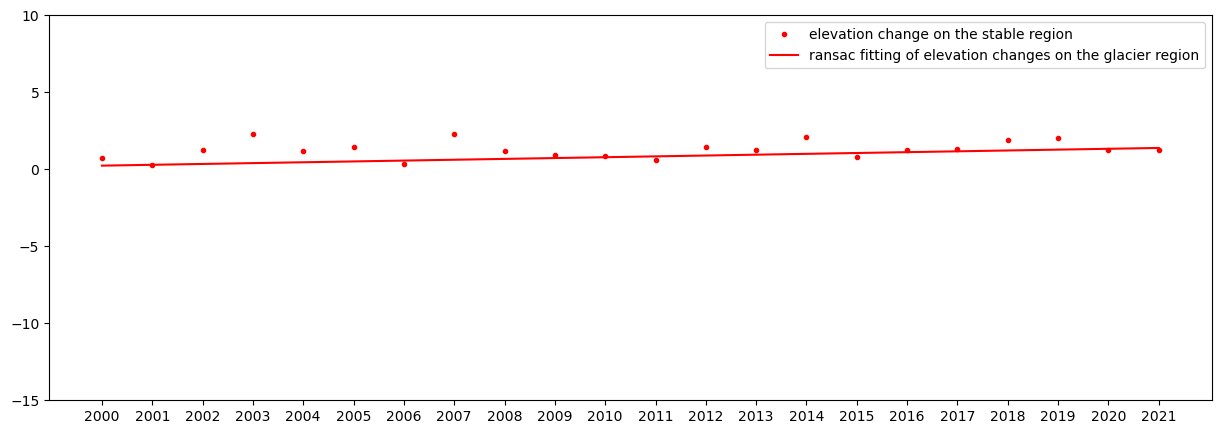

In [51]:
mean_setp_stable_tilesWeighted, std_setp_stable_tilesWeighted = stat_tiles_weighting(mean_tiles = stat_dif_dems_xr['mean_stable_tiles'], \
                                                                    std_tiles = stat_dif_dems_xr['std_stable_tiles'], 
                                                                    glacier_area_tiles = stat_dif_dems_xr['area_glacier_tiles'])
y_filtered_setp_stable, y_fitting_setp_stable, ransac_coef_setp_stable = ransac_fitting(x=x_years, y=mean_setp_stable_tilesWeighted.values, thre_mask=50)
print('Ransac coefficient for stable setp region:', ransac_coef_setp_stable[0])
plt.figure(figsize=(15, 5))
plt.plot(years, mean_setp_stable_tilesWeighted, '.r', label='elevation change on the stable region')
plt.plot(years, y_fitting_setp_stable, '-r', label='ransac fitting of elevation changes on the glacier region')   ### bin-based area weighting -> tile-based area weighting
plt.legend()
plt.ylim(bottom=-15, top=10)



#### 1.3 Check the elevation change on one tile.

Ransac coefficient for stable tile: -0.010882764309062166


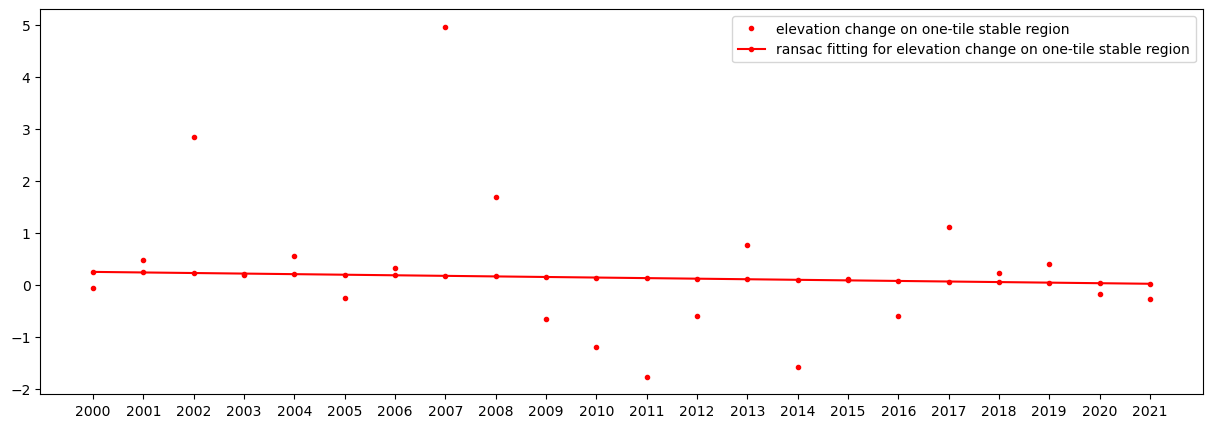

In [52]:
tile_sel = 'tile_29_97'
y_stable_tile_filtered, y_stable_tile_fitting, ransac_coef_stable_tile = ransac_fitting(x=x_years, \
                                        y=stat_dif_dems_xr['mean_stable_tiles'].sel(tiles_id=tile_sel).values, thre_mask=50)
# y_glacier_tile_filtered, y_glacier_tile_fitting, ransac_coef_glacier_tile = ransac_fitting(x=x_years, \
#                                         y=mean_tiles_glacier_binsWeighted.sel(tiles_id=tile_sel).values, thre_mask=50)
print('Ransac coefficient for stable tile:', ransac_coef_stable_tile[0])
# print('Ransac coefficient for glacier tile:', ransac_coef_glacier_tile[0])

plt.figure(figsize=(15, 5))
plt.plot(years, stat_dif_dems_xr['mean_stable_tiles'].sel(tiles_id=tile_sel), '.r', label='elevation change on one-tile stable region')
plt.plot(years, y_stable_tile_fitting, '.-r', label='ransac fitting for elevation change on one-tile stable region')
# plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id='tile_29_97'), '.g', label='elevation change on one-tile glacier region')
# plt.plot(years, y_glacier_tile_fitting, '.-g', label='ransac fitting for elevation change on one-tile')
plt.legend()




### 2. Elevation change on the glacier region.


#### 2.1 Read data

In [53]:
# stat_glacier_tiles_bins_xr = xr.open_dataset(paths_stat_dems_gla)
# stat_glacier_tiles_bins_xr


#### 2.2 Elevation change on the overall setp region.

In [54]:
def stat_bins_tiles_weighting(mean_tiles_bins, std_tiles_bins, glacier_area_tiles_bins):
    """
    des: glacier area-weighted elevation change calculation.
    !!! bins-based glacier area weighting -> tiles-based glacier area weighting.
    args:
        mean_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), mean elevation change for each bin of each tile.
        std_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), standard deviation of elevation change for each bin of each tile.
        glacier_area_bins: xarray.DataArray, (tiles_id, bins_id), glacier area for each bin of each tile.
    return: 
        mean_tiles_weighted: xr.dataarray, glacier-area weighted mean elevation change for each tile. 
        mean_setp_weighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
    """
    ### a) glacier area (bin-based) weighted mean elevation change for each tile.
    glacier_area_tiles_bins_3d = glacier_area_tiles_bins.expand_dims(dim={"time": years}, axis=2)
    glacier_area_tiles_bins_3d = ~np.isnan(mean_tiles_bins)*glacier_area_tiles_bins_3d  ## mask the nan values before area weighting
    glacier_area_tiles_2d = glacier_area_tiles_bins_3d.sum(dim=('bins_id'))
    glacier_area_tiles_3d = glacier_area_tiles_2d.expand_dims(dim={'bins_id': bins_id}, axis=1)
    glacier_area_binsWeight_3d = glacier_area_tiles_bins_3d/glacier_area_tiles_3d   ## (tiles_id, bins_id, years), weights for each bin of each year.
    mean_tiles_binsWeighted = mean_tiles_bins * glacier_area_binsWeight_3d.values  
    mean_tiles_binsWeighted = mean_tiles_binsWeighted.sum(dim=('bins_id'))       ## (tiles_id, years)
    mean_tiles_binsWeighted = mean_tiles_binsWeighted.where(mean_tiles_binsWeighted!=0, np.nan)  # if values == 0, value -> np.nan. 
    std_tiles_binsWeighted = std_tiles_bins * glacier_area_binsWeight_3d
    std_tiles_binsWeighted = std_tiles_binsWeighted.sum(dim=('bins_id'))       ## (tiles_id, years)
    ### b) glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_tiles = glacier_area_tiles_bins.sum(dim='bins_id')   ###（tiles_id,）
    glacier_area_tiles_2d = glacier_area_tiles.expand_dims(dim={'times': years}, axis=1)  ## (tiles_id, years)
    glacier_area_tiles_2d = ~np.isnan(mean_tiles_binsWeighted)*glacier_area_tiles_2d.values  ## (tiles_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_tiles_2d.sum(dim=('tiles_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)   ### (tiles_id, years)    
    glacier_area_tilesWeight_2d = glacier_area_tiles_2d/glacier_area_2d   ### (tiles_id, years)
    mean_setp_tilesWeighted = mean_tiles_binsWeighted*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    mean_setp_tilesWeighted = mean_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)      
    std_setp_tilesWeighted = std_tiles_binsWeighted*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    std_setp_tilesWeighted = std_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   

    return mean_tiles_binsWeighted, std_tiles_binsWeighted, mean_setp_tilesWeighted, std_setp_tilesWeighted


def stat_tiles_bins_weighting(mean_tiles_bins, std_tiles_bins, glacier_area_tiles_bins):
    """
    des: glacier area-weighted elevation change calculation.  
         !!! tiles-based glacier area weighting -> bins-based glacier area weighting.
    args:
        mean_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), mean elevation change for each bin of each tile.
        std_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), standard deviation of elevation change for each bin of each tile.
        glacier_area_tiles_bins: xarray.DataArray, (tiles_id, bins_id), glacier area for each bin of each tile.
    return: 
        mean_tiles_weighted: xr.dataarray, glacier-area weighted mean elevation change for each tile. 
        mean_setp_weighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
    """
    glacier_area_tiles_bins_3d = glacier_area_tiles_bins.expand_dims(dim={"time": years}, axis=2)
    glacier_area_tiles_bins_3d = ~np.isnan(mean_tiles_bins)*glacier_area_tiles_bins_3d.values   ## mask the nan values before area weighting
    glacier_area_bins_2d = glacier_area_tiles_bins_3d.sum(dim=('tiles_id'))   ### (bins_id, years), sumation of area for each bin of setp.
    glacier_area_bins_3d = glacier_area_bins_2d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)  ## (tiles_id, bins_id, years)
    glacier_area_tilesWeight_3d = glacier_area_tiles_bins_3d/glacier_area_bins_3d.values   ### weights for each bin of setp  
    mean_bins_tilesWeighted_3d = mean_tiles_bins*glacier_area_tilesWeight_3d.values
    mean_bins_tilesWeighted = mean_bins_tilesWeighted_3d.sum(dim='tiles_id')   ### (bins_id, years)
    std_bins_tilesWeighted_3d = std_tiles_bins*glacier_area_tilesWeight_3d.values
    std_bins_tilesWeighted = std_bins_tilesWeighted_3d.sum(dim='tiles_id')     ### (bins_id, years)
    ### b) glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_bins = glacier_area_tiles_bins.sum(dim='tiles_id')   ###（bins_id）
    glacier_area_bins_2d = glacier_area_bins.expand_dims(dim={'times': years}, axis=1)  ## (bins_id, years)
    glacier_area_bins_2d = ~np.isnan(mean_bins_tilesWeighted)*glacier_area_bins_2d.values  ## (bins_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_bins_2d.sum(dim=('bins_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'bins_id': bins_id}, axis=0)   ### (bins_id, years)    
    glacier_area_binsWeight_2d = glacier_area_bins_2d/glacier_area_2d              ## (bins_id, years)
    mean_setp_binsWeighted = mean_bins_tilesWeighted*glacier_area_binsWeight_2d    ## (bins_id, years)
    mean_setp_binsWeighted = mean_setp_binsWeighted.sum(dim=('bins_id'))           ## (years,)   
    std_setp_binsWeighted = std_bins_tilesWeighted*glacier_area_binsWeight_2d      ## (bins_id, years)
    std_setp_binsWeighted = std_setp_binsWeighted.sum(dim=('bins_id'))             ## (years,)   
    return mean_bins_tilesWeighted, std_bins_tilesWeighted, mean_setp_binsWeighted, std_setp_binsWeighted




##### 2.2.1 Glacier area weighted elevation change on the glacier region.

In [55]:
stat_dif_dems_xr

<xarray.Dataset>
Dimensions:                  (tiles_id: 28, bins_id: 50, time: 22)
Coordinates:
  * tiles_id                 (tiles_id) object 'tile_31_93' ... 'tile_29_91'
  * bins_id                  (bins_id) object '2500-2600' ... '7400-7500'
  * time                     (time) object '2000' '2001' ... '2020' '2021'
Data variables:
    area_glacier_tiles       (tiles_id) float64 68.09 0.2097 ... 604.8 0.0
    area_glacier_tiles_bins  (tiles_id, bins_id) float64 ...
    mean_stable_tiles        (tiles_id, time) float64 2.192 -0.804 ... 1.39
    std_stable_tiles         (tiles_id, time) float64 ...
    mean_glacier_tiles_bins  (tiles_id, bins_id, time) float64 ...
    std_glacier_tiles_bins   (tiles_id, bins_id, time) float64 ...

In [56]:
# bins_id = stat_glacier_tiles_bins_xr.bins_id.values
# years = stat_glacier_tiles_bins_xr.time.values
### From bins weighting to tiles weighting.
mean_tiles_glacier_binsWeighted, std_tiles_glacier_binsWeighted, mean_setp_glacier_tilesWeighted, std_setp_glacier_tilesWeighted = \
                            stat_bins_tiles_weighting(mean_tiles_bins=stat_dif_dems_xr['mean_glacier_tiles_bins'], \
                                                std_tiles_bins=stat_dif_dems_xr['std_glacier_tiles_bins'], 
                                                glacier_area_tiles_bins=stat_dif_dems_xr['area_glacier_tiles_bins'])

### From tiles weighting to bins weighting.
mean_bins_glacier_tilesWeighted, std_bins_glacier_tilesWeighted, mean_setp_glacier_binsWeighted, std_setp_glacier_binsWeighted = \
                                            stat_tiles_bins_weighting(mean_tiles_bins=stat_dif_dems_xr['mean_glacier_tiles_bins'], \
                                                            std_tiles_bins=stat_dif_dems_xr['std_glacier_tiles_bins'], 
                                                            glacier_area_tiles_bins=stat_dif_dems_xr['area_glacier_tiles_bins'])



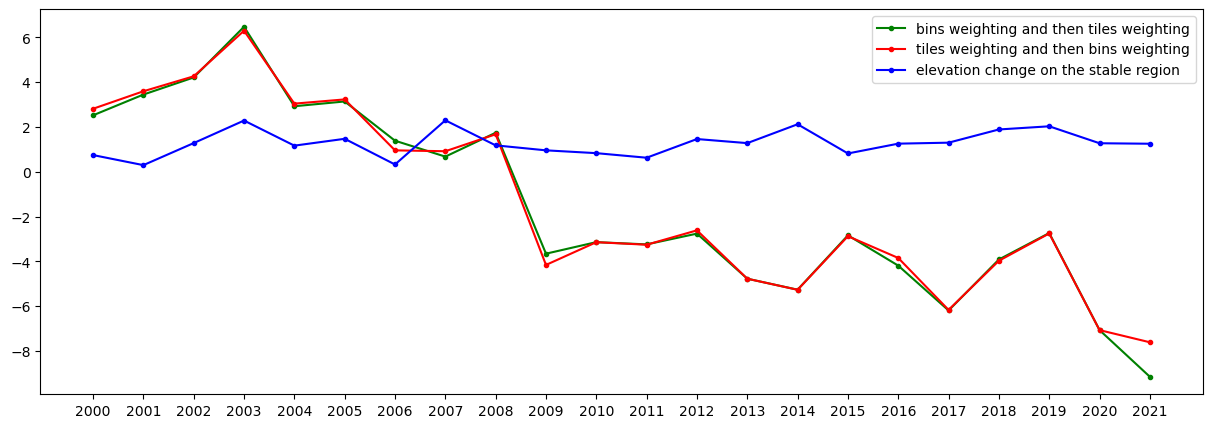

In [57]:
plt.figure(figsize=(15,5))
plt.plot(years, mean_setp_glacier_tilesWeighted, '.-g', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_glacier_binsWeighted, '.-r', label='tiles weighting and then bins weighting')   ### tile-based area weighting -> bin-based area weighting
plt.plot(years, mean_setp_stable_tilesWeighted, '.-b', label='elevation change on the stable region')
plt.legend()


##### 2.2.2 Elevation change correction with elevation chang on the stable region
##### **!!!! Note: the elevation changes much from 2008 to 2009.** 

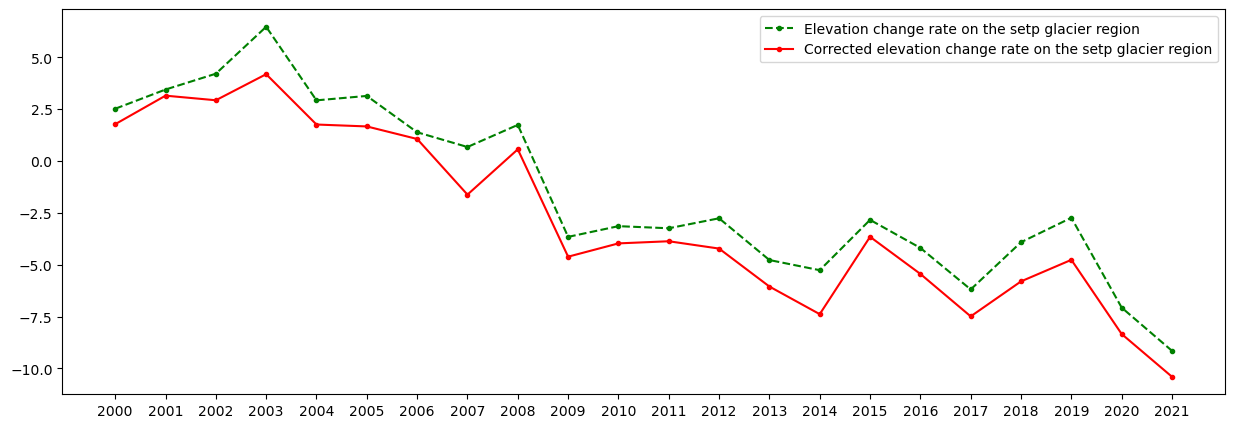

In [58]:
## New method.
### elevation change 
mean_setp_glacier_cor = mean_setp_glacier_tilesWeighted.values - mean_setp_stable_tilesWeighted.values
# y_setp_glacier_cor_filtered, y_setp_glacier_cor_fitting, ransac_coef_setp_glacier_cor = ransac_fitting(x=x_years, \
#                                         y=mean_setp_glacier_cor, thre_mask=50)
### standard deviation of elevation change.
std_setp_glacier_cor = np.sqrt(np.square(std_setp_stable_tilesWeighted.values) + np.square(std_setp_glacier_tilesWeighted.values)) 

# print('Corrected elevation change rate for the overall setp glacier region:', ransac_coef_setp_glacier_cor[0])
plt.figure(figsize=(15, 5))
plt.plot(years, mean_setp_glacier_tilesWeighted.values, '.--g', label='Elevation change rate on the setp glacier region')
plt.plot(years, mean_setp_glacier_cor, '.-r', label='Corrected elevation change rate on the setp glacier region')
# plt.plot(years, y_setp_glacier_cor_fitting, '-r', label='Linear fitting of corrected elevation change rate on the setp glacier region')
plt.legend()



##### 2.2.3 Elevation change rate estimation by ransac algorithm.

Ransac coefficent: -0.607370184581694
Ransac coefficent (2000-2011): -0.3893588488694206
Ransac coefficent (2012-2021): -0.5642210999163819


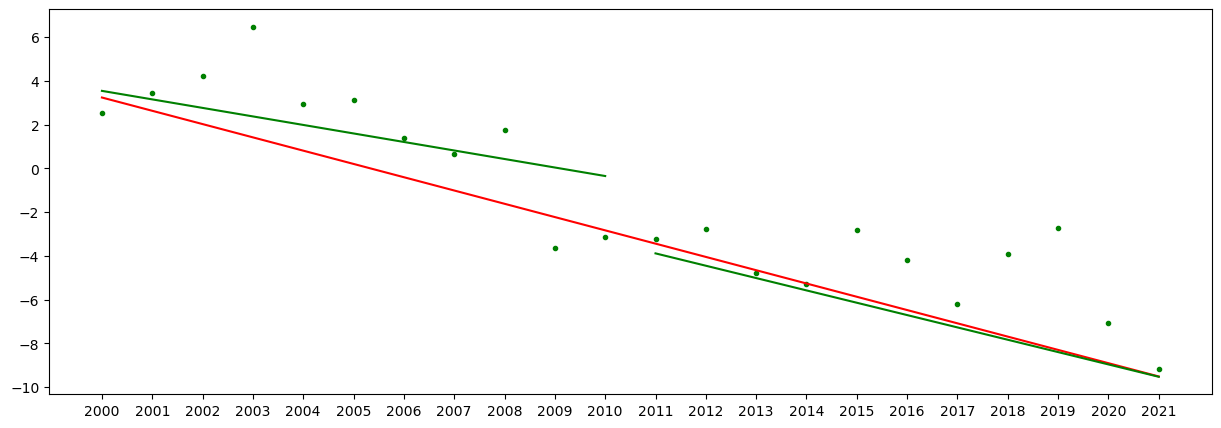

In [59]:
i_year_middle = 11
#### Time interval: 2000-2021
x_years = np.array([i for i in range(len(years))])
y_setp_glacier_cor_filtered, y_setp_glacier_cor_fitting, ransac_coef_setp_glacier_cor = ransac_fitting(x=x_years, \
                                                                y=mean_setp_glacier_cor, thre_mask=50)
print('Ransac coefficent:', ransac_coef_setp_glacier_cor[0])

#### Time interval: 2000-2010
y_setp_glacier_cor_2000_2011_filtered, y_setp_glacier_cor_2000_2011_fitting, ransac_coef_setp_glacier_cor_2000_2011 = ransac_fitting(x=x_years[0:i_year_middle], \
                                                                y=mean_setp_glacier_cor[0:i_year_middle], thre_mask=50)
print('Ransac coefficent (2000-2011):', ransac_coef_setp_glacier_cor_2000_2011[0])

#### Time interval: 2012-2021
y_setp_glacier_cor_2012_2021_filtered, y_setp_glacier_cor_2012_2021_fitting, ransac_coef_setp_glacier_cor_2012_2021 = ransac_fitting(x=x_years[i_year_middle:], \
                                                                y=mean_setp_glacier_cor[i_year_middle:], thre_mask=50)
print('Ransac coefficent (2012-2021):', ransac_coef_setp_glacier_cor_2012_2021[0])

plt.figure(figsize=(15,5))
plt.plot(years, mean_setp_glacier_tilesWeighted.values, '.g')
plt.plot(years, y_setp_glacier_cor_fitting, '-r')
plt.plot(years[0:i_year_middle], y_setp_glacier_cor_2000_2011_fitting, '-g')
plt.plot(years[i_year_middle:], y_setp_glacier_cor_2012_2021_fitting, '-g')



##### 2.2.4 Elevation change rate uncertainty estimation.

In [60]:
#### 1. Time interval: 2000-2021
epsilon = mean_setp_glacier_cor - y_setp_glacier_cor_fitting
sigma_dh = np.std(epsilon)
sigma_dh_dt = sigma_dh/len(years)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt:', sigma_dh_dt)

#### 2. Time interval: 2000-2010
epsilon = mean_setp_glacier_cor[0:i_year_middle] - y_setp_glacier_cor_2000_2011_fitting
sigma_dh_2000_2011 = np.std(epsilon)
sigma_dh_dt_2000_2011 = sigma_dh_2000_2011/mean_setp_glacier_cor[0:i_year_middle].shape[0]
# print('sigma_dh for 2000-2011:', sigma_dh)
print('sigma_dh_dt for 2000-2011:', sigma_dh_dt_2000_2011)

#### 3. Time interval: 2012-2021
epsilon = mean_setp_glacier_cor[i_year_middle:] - y_setp_glacier_cor_2012_2021_fitting
sigma_dh_2012_2021 = np.std(epsilon)
sigma_dh_dt_2012_2021 = sigma_dh_2012_2021/mean_setp_glacier_cor[i_year_middle:].shape[0]
# print('sigma_dh for 2000-2011:', sigma_dh)
print('sigma_dh_dt for 2012-2021:', sigma_dh_dt_2012_2021)



sigma_dh_dt: 0.07183487848815978
sigma_dh_dt for 2000-2011: 0.1664938312535799
sigma_dh_dt for 2012-2021: 0.1425874308557381


##### 2.2.5 Write out the setp glacier elevation change result. 

In [61]:
ele_change_glacier_setp_dict = {
                    'ele_change_cor': mean_setp_glacier_cor,
                    'ele_change_cor_error': std_setp_glacier_cor,           
                    'ele_change_cor_fitting': y_setp_glacier_cor_fitting,
                    'ele_change_cor_rate': ransac_coef_setp_glacier_cor[0],
                    'ele_change_cor_rate_error': sigma_dh_dt,
                    }
ele_change_glacier_setp_pd = pd.DataFrame(ele_change_glacier_setp_dict)

### Write out as .csv file.
ele_change_glacier_setp_pd.to_csv(path_result_setp, index=False)



#### 2.3 Elevation change of tiles.


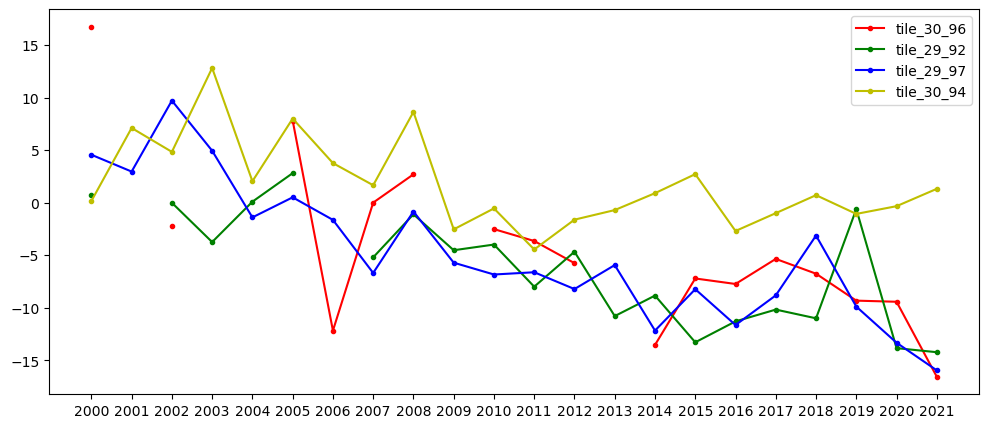

In [62]:
tile_id_1, tile_id_2, tile_id_3, tile_id_4 = 'tile_30_96', 'tile_29_92', 'tile_29_97', 'tile_30_94'
plt.figure(figsize=(12,5))
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_1).values, '.-r', label=tile_id_1)
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_2), '.-g', label=tile_id_2)
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_3), '.-b', label=tile_id_3)
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_4), '.-y', label=tile_id_4)
plt.legend()



#### 2.3.1 Elevation change rate estimation with corrected elevation change, and write out

In [63]:
# tile_id =  'tile_27_98'
tiles_id = mean_tiles_glacier_binsWeighted['tiles_id'].values
ele_rate_tiles = {}
ele_rate_error_tiles = {}
glacier_area_tiles = {}
for tile_id in tiles_id:
  # tile_id =  'tile_27_98'
  mean_tile_glacier = mean_tiles_glacier_binsWeighted.sel(tiles_id=tile_id).values
  mean_tile_stable = stat_dif_dems_xr['mean_stable_tiles'].sel(tiles_id=tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable
  if not np.isnan(mean_tile_glacier_cor).all():
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, ransac_coef_tile_glacier_cor = ransac_fitting(x=x_years, \
                                            y=mean_tile_glacier_cor, thre_mask=50)
    ele_rate_tiles[tile_id] = ransac_coef_tile_glacier_cor[0]
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years)
    ele_rate_error_tiles[tile_id] = sigma_dh_dt
  else: 
    ele_rate_tiles[tile_id] = np.nan
    ele_rate_error_tiles[tile_id] = np.nan
# ele_rate_tiles



In [64]:
### convert to tiles_id to lat_id and lon_id.
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id:
    tiles_lat.append(int(tile_id[5:7])) 
    tiles_lon.append(int(tile_id[8:]))
### create pandas file.
ele_change_glacier_tiles_dict = {
                    'tiles_lat': tiles_lat,
                    'tiles_lon': tiles_lon,
                    'glacier_area':stat_dif_dems_xr['area_glacier_tiles'].values, 
                    'ele_change_rate': ele_rate_tiles.values(),
                    'ele_change_rate_error': ele_rate_error_tiles.values()                    
                    }
ele_change_glacier_tiles_pd = pd.DataFrame(ele_change_glacier_tiles_dict)
ele_change_glacier_tiles_pd.head()
ele_change_glacier_tiles_pd
# ### write out.
# ele_change_glacier_tiles_pd.to_csv(path_result_tiles, index=False)



,tiles_lat,tiles_lon,glacier_area,ele_change_rate,ele_change_rate_error
0,31,93,68.0895,-0.448597,0.146962
1,31,92,0.2097,NaN,NaN
2,29,96,1849.4739,-0.666372,0.123457
3,28,95,0.0000,NaN,NaN
4,27,98,0.3717,3.772779,0.718201
5,28,98,138.5892,-0.672155,0.139090
6,28,97,179.9793,-0.673242,0.214363
7,31,94,1.7577,-0.596743,0.284685
8,29,93,106.4790,-0.665493,0.156342
9,27,96,0.0000,NaN,NaN


Text(0.5, 1.0, 'elevation change rate of tiles')

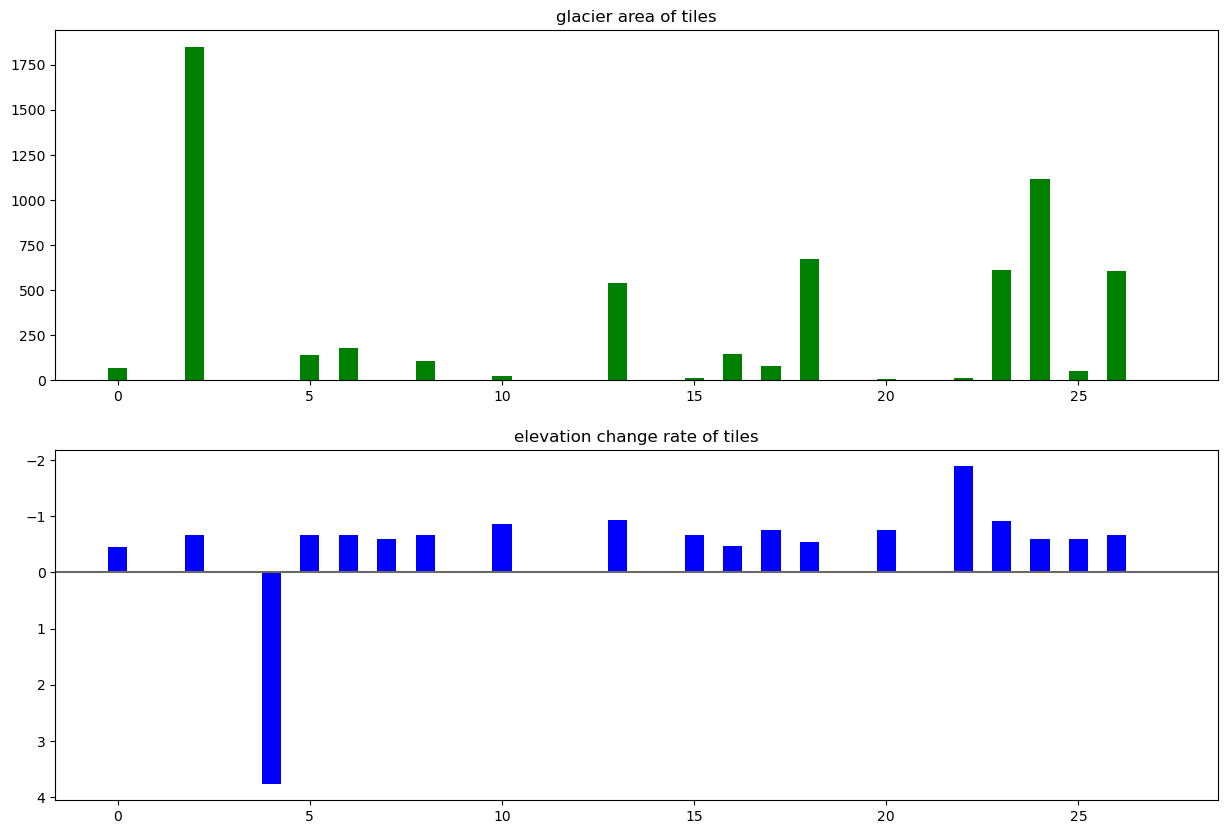

In [65]:
plt.figure(figsize =(15, 10))
num_tiles = len(tiles_id)
width = 0.5
ax1 = plt.subplot(2,1,1)
ax1.bar(np.arange(num_tiles), ele_change_glacier_tiles_pd['glacier_area'], color='g', width=width)
plt.title('glacier area of tiles')

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.axhline(y=0, color='dimgray', linestyle='-')
ax2.bar(np.arange(num_tiles), ele_change_glacier_tiles_pd['ele_change_rate'], color='b',width=width)
ax2.invert_yaxis()
plt.title('elevation change rate of tiles')



#### 3. Elevation changes of elevation bins.
##### !!! Note: the elevation change of bins is not corrected because the area of stable region of bins is largely unbalanced. 


In [66]:
### Calculate elevation change rate for each bin.
ransac_coef_bins = []
ele_change_bins = []
glacier_area_bins = []
ele_rate_error_bins = []
for bin_id in mean_bins_glacier_tilesWeighted.bins_id.values:
    ele_change_bin = mean_bins_glacier_tilesWeighted.sel(bins_id=bin_id).values
    ele_change_bin = np.where(ele_change_bin == 0, np.nan, ele_change_bin)
    if not np.isnan(ele_change_bin).all():
        y_filtered_bin_glacier, y_fitting_bin_glacier, ransac_coef_bin_glacier = ransac_fitting(x=x_years, y=ele_change_bin, thre_mask=50)
        ransac_coef_bins.append(ransac_coef_bin_glacier[0])
        ele_change_bins.append(ele_change_bin)
        ## Uncertainty.
        epsilon =  ele_change_bin - y_fitting_bin_glacier
        sigma_dh = np.nanstd(epsilon)
        sigma_dh_dt = sigma_dh/len(years)
        ele_rate_error_bins.append(sigma_dh_dt)
    else:
        ransac_coef_bins.append(np.nan)
        ele_change_bins.append(np.nan)
        ele_rate_error_bins.append(np.nan)
glacier_area_bins = stat_dif_dems_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values
# ransac_coef_bins



Text(0.5, 1.0, 'selected tile')

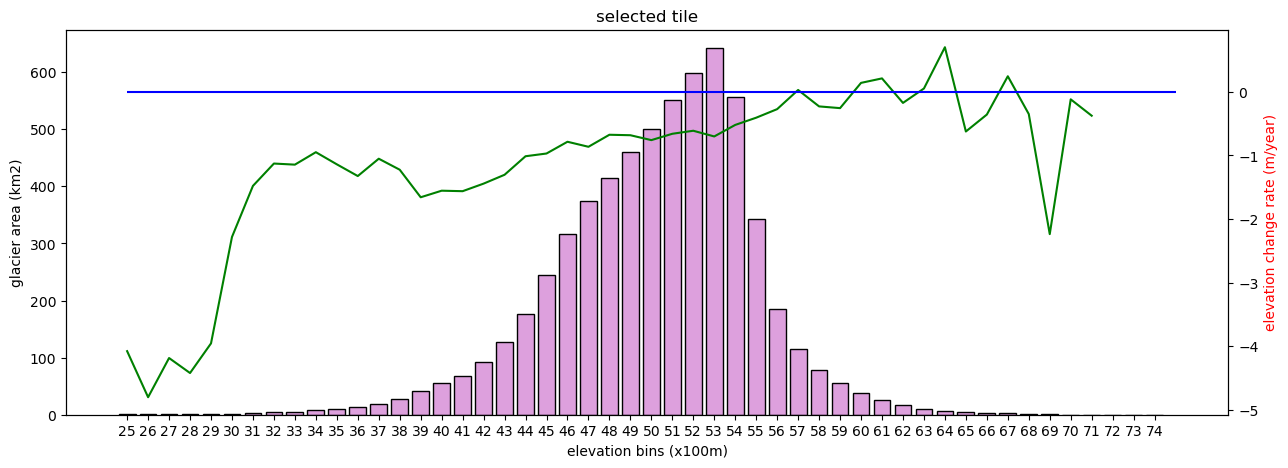

In [67]:
bins_id_start = [bin_id[0:2] for bin_id in bins_id]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax1.bar(bins_id_start, glacier_area_bins, color ='Plum', edgecolor ='black')
ax1.set_ylabel('glacier area (km2)')
ax1.set_xlabel('elevation bins (x100m)')
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax2.set_ylabel('elevation change rate (m/year)', color='red')
ax2.plot(ransac_coef_bins, 'g')
ax2.hlines(y=0, xmin=0, xmax=50, colors='blue')
# plt.xticks([1, 25, 50], [2500, 5000, 7500])
plt.xlabel('elevation (m)')
plt.title('selected tile')


In [68]:
ele_change_glacier_bins_dict = {
                    'bins_id': bins_id,
                    'glacier_area':glacier_area_bins, 
                    'ele_change_rate': ransac_coef_bins,
                    'ele_change_rate_error': ele_rate_error_bins                  
                    }
ele_change_glacier_bins_pd = pd.DataFrame(ele_change_glacier_bins_dict)
ele_change_glacier_bins_pd.head()
ele_change_glacier_bins_pd
# ### write out.
# ele_change_glacier_bins_pd.to_csv(path_result_bins, index=False)


,bins_id,glacier_area,ele_change_rate,ele_change_rate_error
0,2500-2600,0.4356,-4.077777,0.286732
1,2600-2700,0.7992,-4.802509,0.367617
2,2700-2800,1.0935,-4.185986,0.564763
3,2800-2900,1.4742,-4.422009,0.711833
4,2900-3000,2.0781,-3.955774,0.262811
5,3000-3100,1.9962,-2.282228,0.295833
6,3100-3200,3.3813,-1.478528,0.319319
7,3200-3300,4.5045,-1.127101,0.253776
8,3300-3400,5.5737,-1.144372,0.133068
9,3400-3500,8.3844,-0.948457,0.459886
